# Plotting example for either prompt/final hits or possible rock muons hits

If you have a nersc account and can ssh into perlmutter, the directory for MR5 files is --------- (Liz does not currently have one)

If you do not have a nersc account, go to https://portal.nersc.gov/project/dune/data/2x2/simulation/productions/MiniRun5_1E19_RHC/MiniRun5_1E19_RHC.flow.beta1/FLOW/0000000/ , and you can download one of the MR5 files to get started with.

In [79]:
#Imports
import numpy as np

import h5py

import plotly.graph_objects as go
import matplotlib.pyplot as plt
import mplhep as hep

In [80]:
'''

Get file, this will download it in your present working directory

Uncomment this wget if you need a file, note this file is quite large. I believe it is around 1 GB.

'''
#!wget -P . https://portal.nersc.gov/project/dune/data/2x2/simulation/productions/MiniRun5_1E19_RHC/MiniRun5_1E19_RHC.flow.beta1/FLOW/0000000/MiniRun5_1E19_RHC.flow.0000000.FLOW.hdf5

# Ways to read h5 files, update I am not using the h5flow because I can't figure out how to list all the dsets in the file.

f_name = '/global/homes/d/demaross/MiniRun5_1E19_RHC.flow.0000000.FLOW.hdf5' #This should be whatever directory the MR5 files is in, I will just be using one of my rock muon files

#h5py way

f = h5py.File(f_name, 'r')

print('Datasets in the file :', f.keys())

print('You can do .keys() to see each key in all datasets')

print('Charge keys:', f['charge'].keys()) 

print('Calib_prompt_hits keys:',  f['charge/calib_prompt_hits'].keys())

Datasets in the file : <KeysViewHDF5 ['charge', 'combined', 'geometry_info', 'lar_info', 'light', 'mc_truth', 'run_info']>
You can do .keys() to see each key in all datasets
Charge keys: <KeysViewHDF5 ['calib_final_hits', 'calib_prompt_hits', 'events', 'ext_trigs', 'packets', 'packets_corr_ts', 'raw_events', 'raw_hits']>
Calib_prompt_hits keys: <KeysViewHDF5 ['data', 'ref']>


In [81]:
#Lets get the prompt hits

PromptHits = f['charge/calib_prompt_hits/data']

print('We can see what each column means by doing PromptHits.dtype:', PromptHits.dtype)

We can see what each column means by doing PromptHits.dtype: [('id', '<u4'), ('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('t_drift', '<f8'), ('ts_pps', '<u8'), ('io_group', '<u8'), ('io_channel', '<u8'), ('Q', '<f8'), ('E', '<f8')]


In [82]:
#Detector boundaries for MR5, for MR4 just minus 268 fromt y_boundaries and add 1300 to z_boundaries

x_boundaries = np.array([-63.931, -3.069, 3.069, 63.931])
y_boundaries = np.array([-42-19.8543, -42+103.8543])
z_boundaries = np.array([-64.3163,  -2.6837, 2.6837, 64.3163]) 


#Plotting functions
def draw_cathode_planes(x_boundaries, y_boundaries, z_boundaries, **kwargs):
    
    traces = []
    for i_z in range(int(len(z_boundaries)/2)):
        for i_x in range(int(len(x_boundaries)/2)):
            z, y = np.meshgrid(np.linspace(z_boundaries[i_z * 2], z_boundaries[i_z * 2 + 1], 2), np.linspace(y_boundaries.min(), y_boundaries.max(),2))
            x = (x_boundaries[i_x * 2] + x_boundaries[i_x * 2 + 1]) * 0.5 * np.ones(z.shape)

            traces.append(go.Surface(x=x, y=y, z=z, **kwargs))
    return traces

def draw_anode_planes(x_boundaries, y_boundaries, z_boundaries, **kwargs):
    
    traces = []
    for i_z in range(int(len(z_boundaries)/2)):
        for i_x in range(int(len(x_boundaries))):           
            z, y = np.meshgrid(np.linspace(z_boundaries[i_z * 2], z_boundaries[i_z * 2 + 1], 2), np.linspace(y_boundaries.min(), y_boundaries.max(),2))
            x = x_boundaries[i_x] * np.ones(z.shape)

            traces.append(go.Surface(x=x, y=y, z=z, **kwargs))
    return traces

def plot_segs(segs, **kwargs):
    
    def to_list(axis):
        return np.column_stack([
            segs[f'{axis}_start'],
            segs[f'{axis}_end'],
            np.full(len(segs), None)
        ]).flatten().tolist()
        
    x, y, z = (to_list(axis) for axis in 'xyz')

    trace = go.Scatter3d(x=x, y=y, z=z, **kwargs)
    
    return trace

def vtx_in_LArActive(vtx, x_boundaries, y_boundaries, z_boundaries):
    vtx_in_Active = False
    if vtx[0] >= np.min(x_boundaries) and vtx[0] <= np.max(x_boundaries):
        if vtx[1] >= np.min(y_boundaries) and vtx[1] <= np.max(y_boundaries):
            if vtx[2] >= np.min(z_boundaries) and vtx[2] <= np.max(z_boundaries):
                vtx_in_Active = True
    
    return vtx_in_Active

In [130]:
#Lets plot an prompt hits for a certain event

hit_ref_slice = f['charge/events/ref/charge/calib_prompt_hits/ref_region'][9] #Event 0

PromptHits_ev= f['charge/calib_prompt_hits/data'][hit_ref_slice[0]:hit_ref_slice[1]]

fig = go.Figure()

plot_outActive_vertices = False

##########################
# Draw the cathodes
##########################
fig.add_traces(draw_cathode_planes(
    x_boundaries, y_boundaries, z_boundaries, 
    showscale=False,
    opacity=0.3,
    colorscale='Greys',
))

##########################
# Draw the anodes
##########################
fig.add_traces(draw_anode_planes(
    x_boundaries, y_boundaries, z_boundaries, 
    showscale=False,
    opacity=0.1,
    colorscale='ice',
))

# Draw the prompt hits
##########################
PHits_traces = go.Scatter3d(
        x= PromptHits_ev['x'].flatten(), y= PromptHits_ev['y'].flatten(), z= PromptHits_ev['z'].flatten(),
        marker_color= PromptHits_ev['id'],
        name='prompt hits',
        mode='markers',
        visible='legendonly',
        marker_size=3,
        marker_symbol='square',
        showlegend=True,
        opacity=0.7,)
fig.add_traces(PHits_traces)


fig.show()

event 0 : number of calib_final_hits = 1050


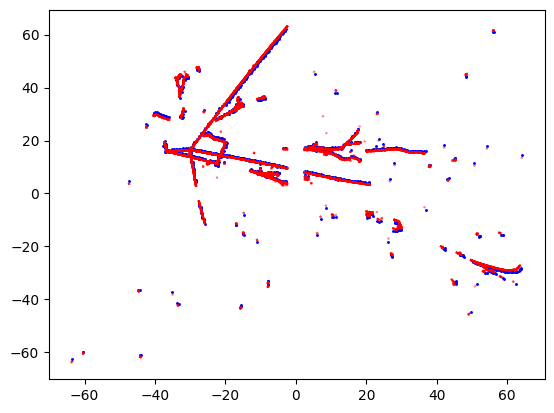

event 0 : number of calib_prompt_hits = 1719


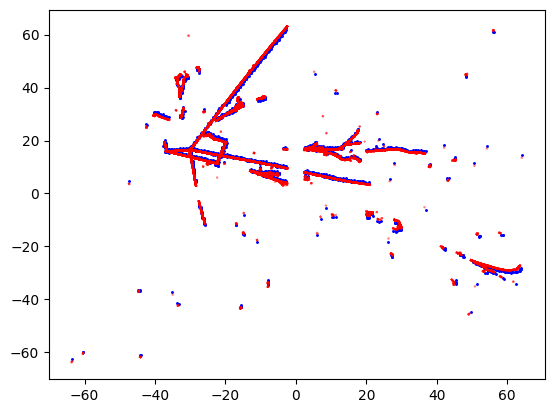

event 1 : number of calib_final_hits = 0


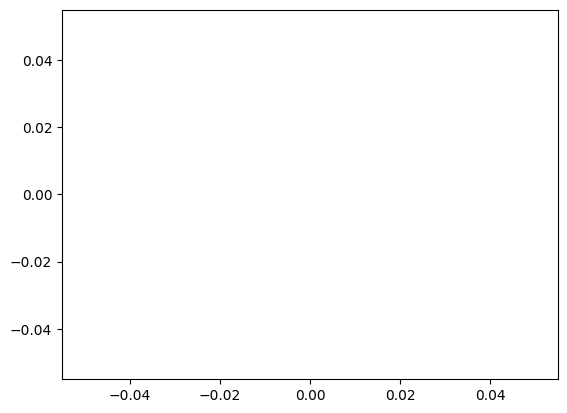

event 1 : number of calib_prompt_hits = 0


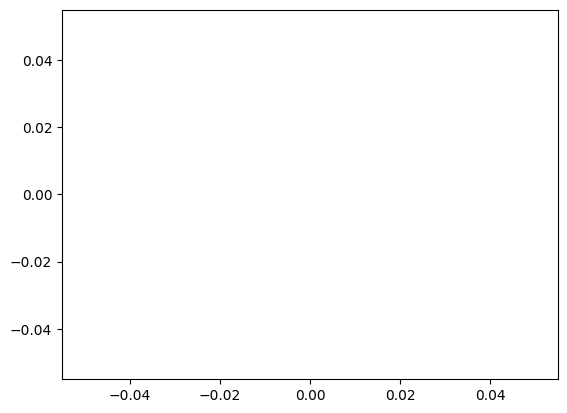

event 2 : number of calib_final_hits = 20


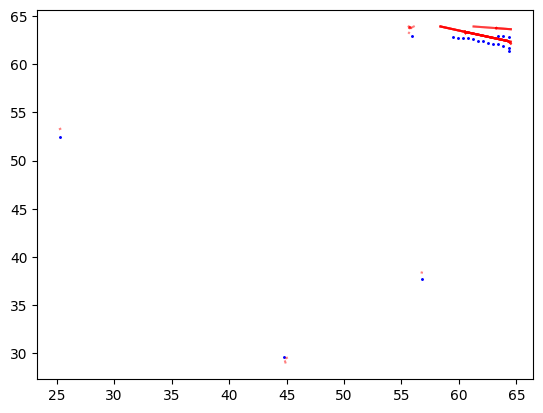

event 2 : number of calib_prompt_hits = 22


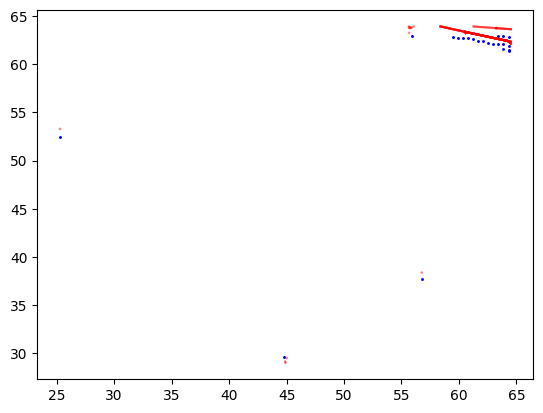

event 3 : number of calib_final_hits = 10


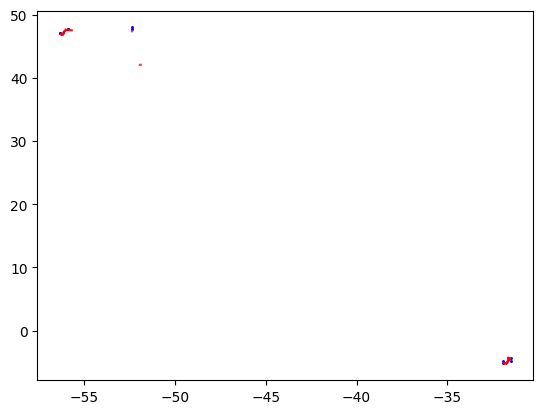

event 3 : number of calib_prompt_hits = 14


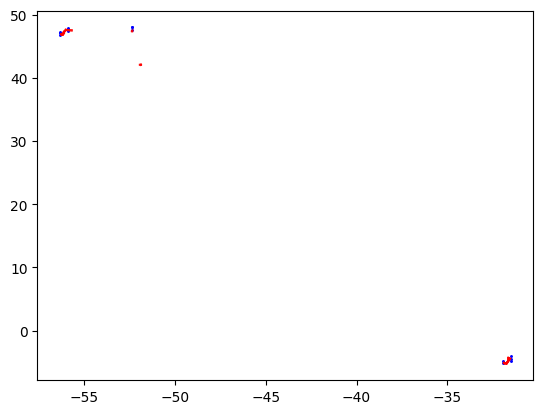

event 4 : number of calib_final_hits = 371


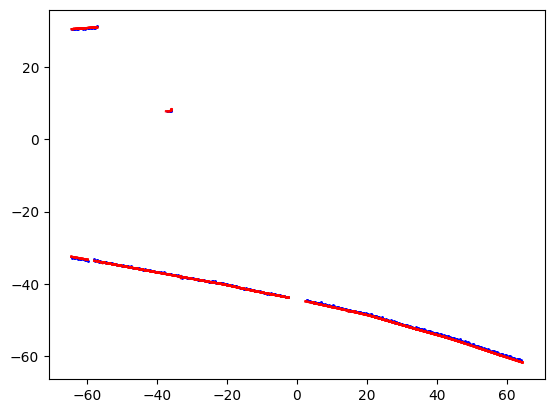

event 4 : number of calib_prompt_hits = 433


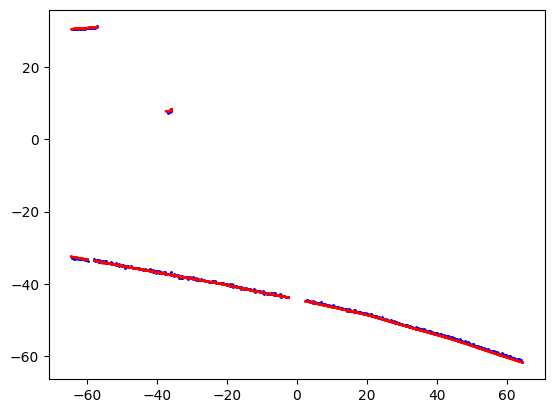

event 5 : number of calib_final_hits = 3


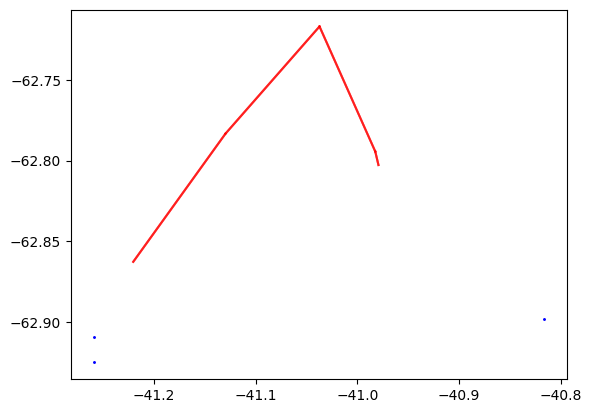

event 5 : number of calib_prompt_hits = 4


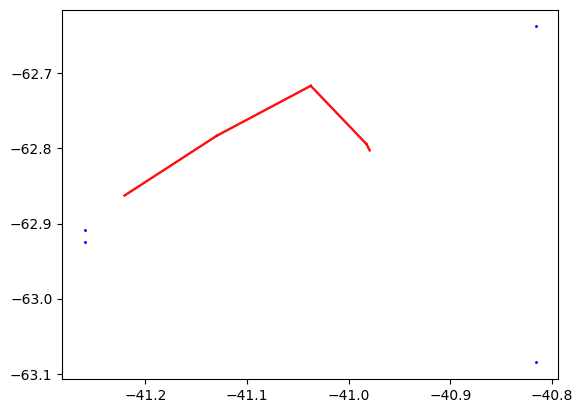

event 6 : number of calib_final_hits = 10


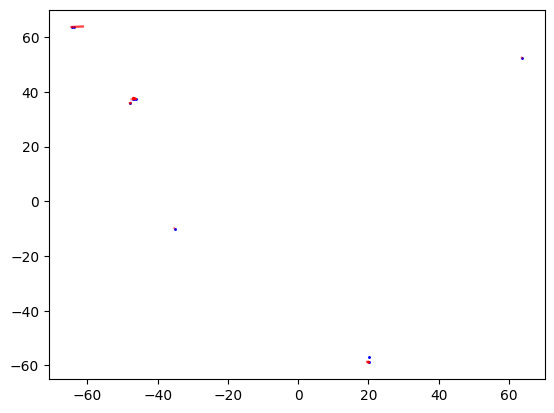

event 6 : number of calib_prompt_hits = 12


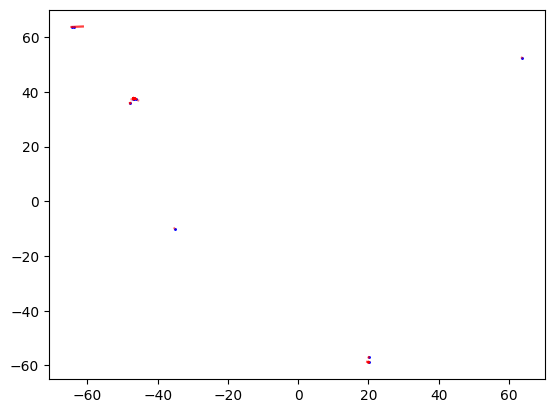

event 7 : number of calib_final_hits = 27


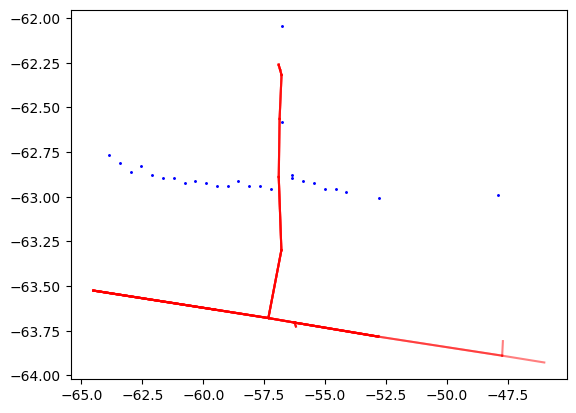

event 7 : number of calib_prompt_hits = 29


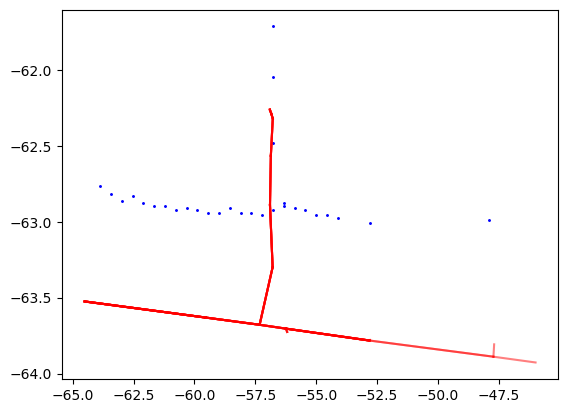

event 8 : number of calib_final_hits = 64


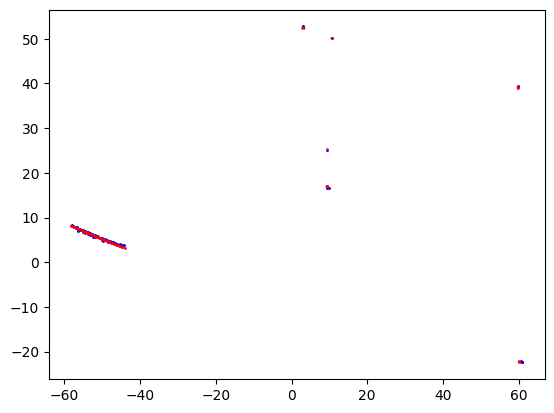

event 8 : number of calib_prompt_hits = 100


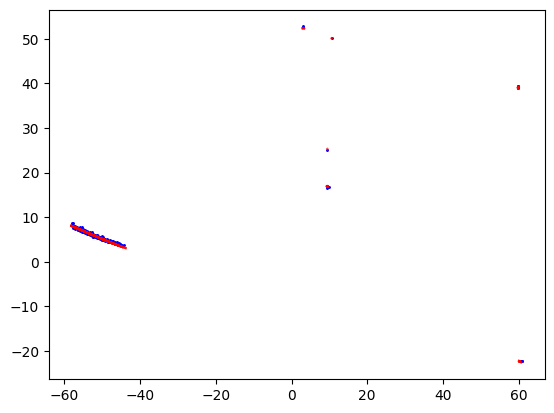

event 9 : number of calib_final_hits = 586


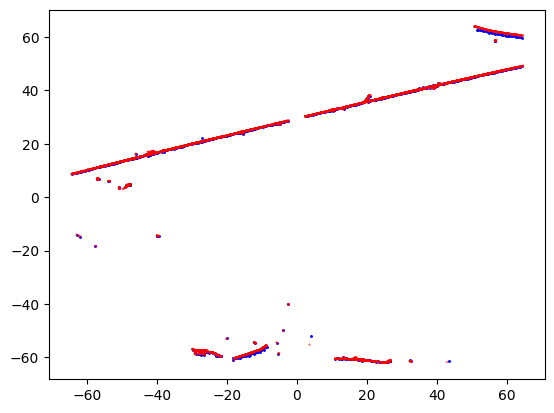

event 9 : number of calib_prompt_hits = 885


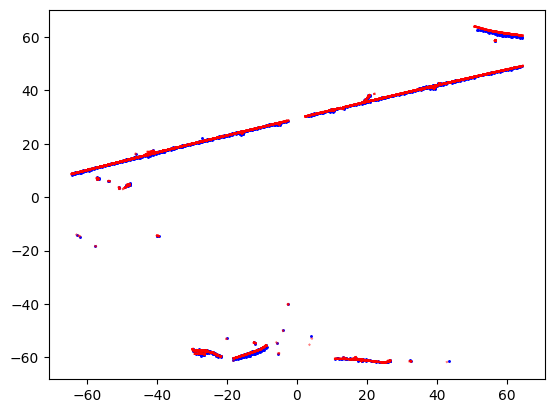

In [97]:
#Backtrack plotting
def draw_event_bt(infile,event_number,hits_dset_name):
    hit_ref_slice = infile['charge/events/ref/charge/'+hits_dset_name+'/ref_region'][event_number]
    hits = infile['charge/'+hits_dset_name+'/data'][hit_ref_slice[0]:hit_ref_slice[1]]
    hits_bt = infile['mc_truth/'+hits_dset_name[:-1]+'_backtrack/data'][hit_ref_slice[0]:hit_ref_slice[1]]
    segments = infile['mc_truth/segments/data']
    print('event', event_number,':', 'number of',hits_dset_name,'=',len(hits))

    # plot al hits from this event in z-y:
    plt.scatter(hits['z'],hits['x'],c='b',alpha=1.0,s=1.2)
    
    
    # plot all of the back tracked segment positions:
    for hit in hits_bt:
        for cont in range(len(hit['fraction'])):
            if abs(hit['fraction'][cont]) > 0.0001:
                seg_id = hit['segment_id'][cont]
                seg = segments[seg_id]
                if not seg['segment_id'] == seg_id:
                    print('WARNING: segment id not the same as segment index!')
                plt.plot([seg['z_start'],seg['z_end']],[seg['x_start'],seg['x_end']],c='r',alpha=0.5)
    plt.show()

#This will plot/backtrack for the first 5 events in this datafile
for event in range(10):
    draw_event_bt(f,event,'calib_final_hits')
    draw_event_bt(f,event,'calib_prompt_hits')

# Using h5flow

If you do not have h5flow, you can figure out how to install it by going to https://github.com/lbl-neutrino/h5flow/tree/main

This is my favorite way to do this.

In [104]:
#Imports
import numpy as np

import plotly.graph_objects as go
import matplotlib.pyplot as plt
import mplhep as hep

import h5flow
from h5flow.data import dereference

In [105]:
f_name = '/global/homes/d/demaross/MiniRun5_1E19_RHC.flow.0000000.FLOW.hdf5'

f_manager = f_manager = h5flow.data.H5FlowDataManager(f_name, 'r')

In [108]:
PromptHits = f_manager["charge/events", "charge/calib_prompt_hits"]

Segs_PromptHits = f_manager["charge/raw_events","charge/calib_prompt_hits", "charge/packets" ,"mc_truth/segments"] #Segments of prompthits

In [119]:
print('The shape of the PromptHits = ', np.shape(PromptHits), 'where the first index is the event')

#Lets use the 100th event

PromptHits_ev = PromptHits[30]

Segs_PromptHits_ev = Segs_PromptHits[30]

The shape of the PromptHits =  (191, 4744) where the first index is the event


In [124]:
fig = go.Figure()

plot_outActive_vertices = False

##########################
# Draw the cathodes
##########################
fig.add_traces(draw_cathode_planes(
    x_boundaries, y_boundaries, z_boundaries, 
    showscale=False,
    opacity=0.3,
    colorscale='Greys',
))

##########################
# Draw the anodes
##########################
fig.add_traces(draw_anode_planes(
    x_boundaries, y_boundaries, z_boundaries, 
    showscale=False,
    opacity=0.1,
    colorscale='ice',
))

# Draw the prompt hits
##########################
PHits_traces = go.Scatter3d(
        x= PromptHits_ev['x'].flatten(), y= PromptHits_ev['y'].flatten(), z= PromptHits_ev['z'].flatten(),
        marker_color= PromptHits_ev['id'],
        name='prompt hits',
        mode='markers',
        visible='legendonly',
        marker_size=3,
        marker_symbol='square',
        showlegend=True,
        opacity=0.7,)
fig.add_traces(PHits_traces)

##########################
# Draw associated segments
##########################
Segs_traces = plot_segs(Segs_PromptHits_ev[:,0,0], 
                    mode="lines",
                    name="edep segments",
                    visible='legendonly',
                    line_color='red',
                    showlegend=True
                    )
fig.add_traces(Segs_traces)

fig.update_layout(
    width=1024, height=768,
    legend_orientation="h",
    scene = dict(xaxis_title='x [cm]',
                yaxis_title='y [cm]',
                zaxis_title='z [cm]')    
)

fig.show()


event 20 : number of calib_final_hits = 0


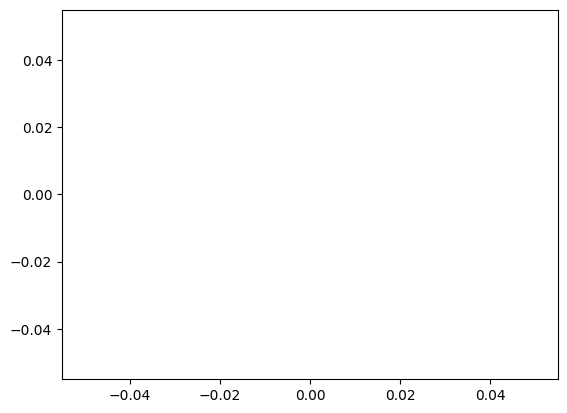

event 20 : number of calib_prompt_hits = 0


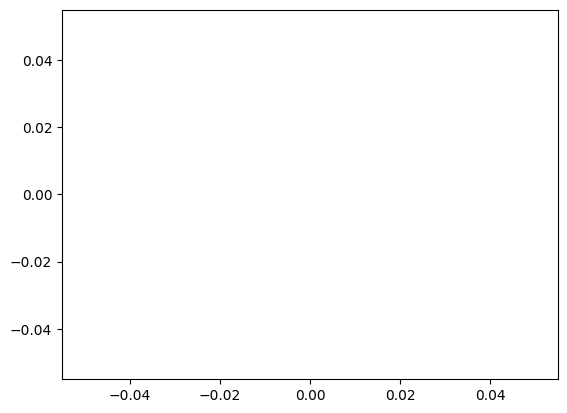

event 21 : number of calib_final_hits = 1246


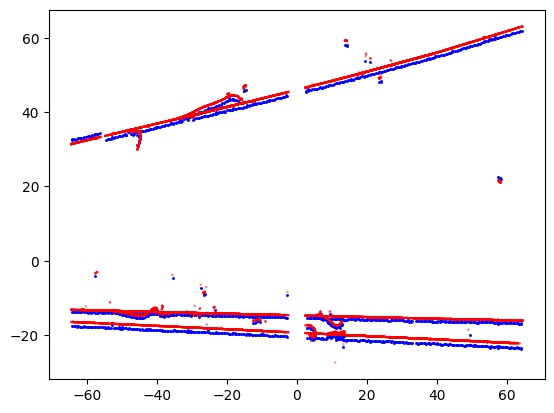

event 21 : number of calib_prompt_hits = 1735


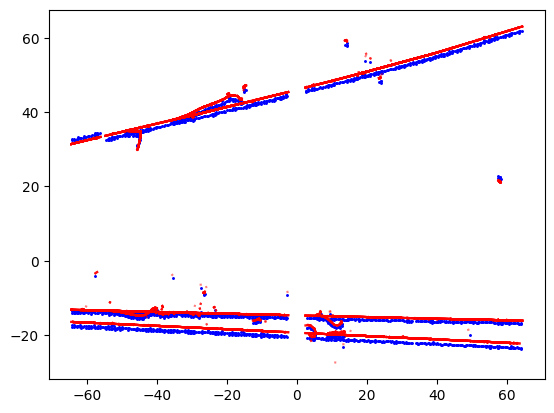

event 22 : number of calib_final_hits = 390


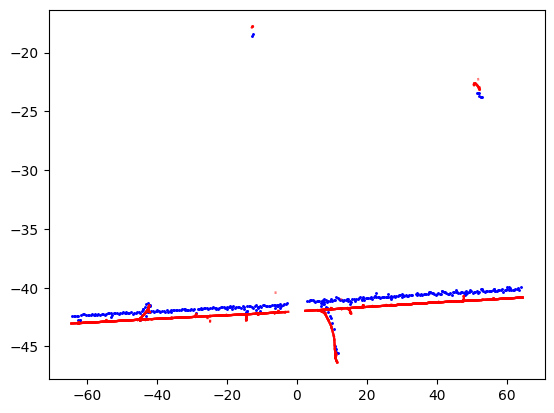

event 22 : number of calib_prompt_hits = 513


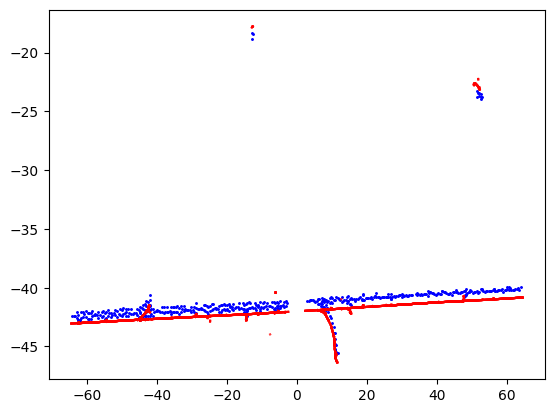

event 23 : number of calib_final_hits = 0


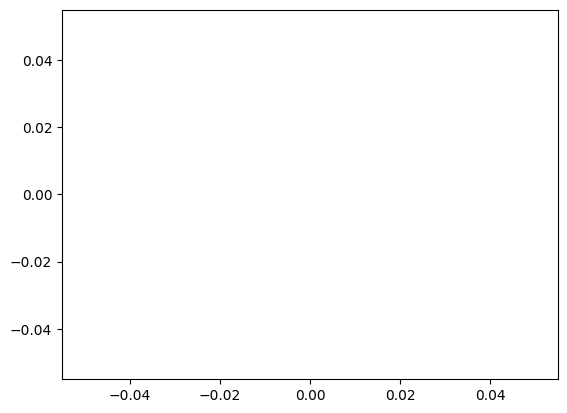

event 23 : number of calib_prompt_hits = 0


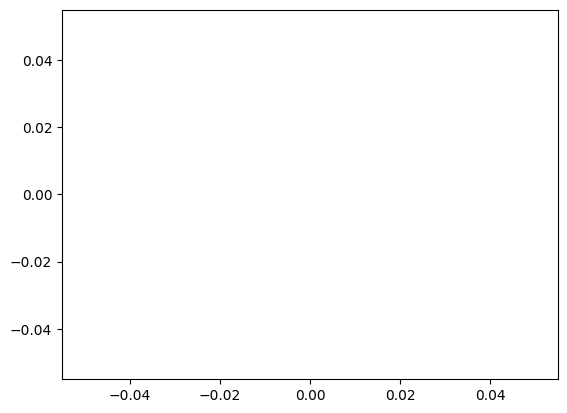

event 24 : number of calib_final_hits = 211


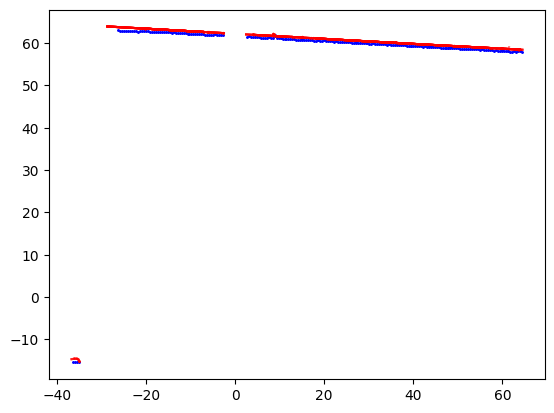

event 24 : number of calib_prompt_hits = 294


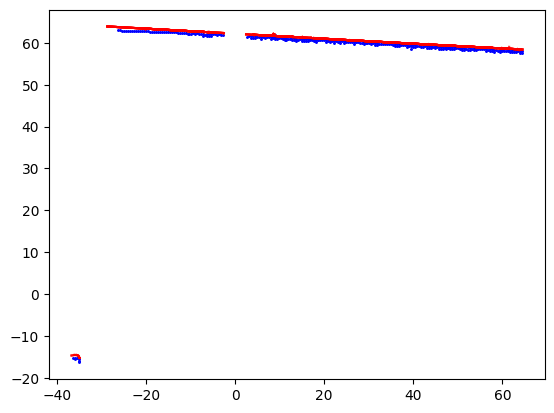

In [129]:
#Backtrack plotting
def draw_event_bt(infile,event_number,hits_dset_name):
    hit_ref_slice = infile['charge/events/ref/charge/'+hits_dset_name+'/ref_region'][event_number]
    hits = infile['charge/'+hits_dset_name+'/data'][hit_ref_slice[0]:hit_ref_slice[1]]
    hits_bt = infile['mc_truth/'+hits_dset_name[:-1]+'_backtrack/data'][hit_ref_slice[0]:hit_ref_slice[1]]
    segments = infile['mc_truth/segments/data']
    print('event', event_number,':', 'number of',hits_dset_name,'=',len(hits))

    # plot al hits from this event in z-y:
    plt.scatter(hits['z'],hits['x'],c='b',alpha=1.0,s=1.2)
    
    
    # plot all of the back tracked segment positions:
    for hit in hits_bt:
        for cont in range(len(hit['fraction'])):
            if abs(hit['fraction'][cont]) > 0.0001:
                seg_id = hit['segment_id'][cont]
                seg = segments[seg_id]
                if not seg['segment_id'] == seg_id:
                    print('WARNING: segment id not the same as segment index!')
                plt.plot([seg['z_start'],seg['z_end']],[seg['x_start'],seg['x_end']],c='r',alpha=0.5)
    plt.show()

#This will plot/backtrack for some events in this datafile
for event in range(20,25):
    draw_event_bt(f_manager,event,'calib_final_hits')
    draw_event_bt(f_manager,event,'calib_prompt_hits')